In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
sns.set()
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

In [4]:
start_year = 2011
end_year = 2017
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])

pudl_out_ferc1 = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)
steam_ferc1 = (
    pudl_out_ferc1.plants_steam_ferc1().
    query("report_year>=@start_year and report_year<=@end_year")
)
fuel_ferc1 = (
    pudl_out_ferc1.fuel_ferc1().
    drop_duplicates(subset=['record_id']).
    query("report_year>=@start_year and report_year<=@end_year")
)

pudl_out_eia = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine, freq="AS")
mcoe_df = pudl_out_eia.mcoe()

/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [5]:
nf = pudl.transform.ferc1.fuel_by_plant_ferc1(fuel_ferc1)
nf.sample(10)

,utility_id_ferc1,plant_name_ferc1,report_year,coal_fraction_mmbtu,gas_fraction_mmbtu,nuclear_fraction_mmbtu,oil_fraction_mmbtu,other_fraction_mmbtu,waste_fraction_mmbtu,fuel_mmbtu,coal_fraction_cost,gas_fraction_cost,nuclear_fraction_cost,oil_fraction_cost,other_fraction_cost,waste_fraction_cost,fuel_cost,primary_fuel_by_mmbtu,primary_fuel_by_cost
2776,141,port westward 2,2015,0.000000,1.000000,0.0,0.000000,0.0,0.000000,3.059213e+06,0.000000,1.000000,0.0,0.000000,0.0,0.00000,1.001224e+07,gas,gas
2787,144,cayuga,2012,0.998880,0.000000,0.0,0.001120,0.0,0.000000,4.948640e+07,0.991768,0.000000,0.0,0.008232,0.0,0.00000,1.525912e+08,coal,coal
4306,193,presque isle-total,2017,1.000000,0.000000,0.0,0.000000,0.0,0.000000,1.088327e+07,1.000000,0.000000,0.0,0.000000,0.0,0.00000,2.493184e+07,coal,coal
4830,227,sumpter,2015,0.000000,1.000000,0.0,0.000000,0.0,0.000000,2.942447e+06,0.000000,1.000000,0.0,0.000000,0.0,0.00000,1.201380e+07,gas,gas
5082,432,generating station,2016,0.000000,1.000000,0.0,0.000000,0.0,0.000000,1.573107e+06,0.000000,1.000000,0.0,0.000000,0.0,0.00000,6.083313e+06,gas,gas
4390,194,neenah,2011,0.000000,0.965423,0.0,0.034577,0.0,0.000000,3.439003e+05,0.000000,0.841298,0.0,0.158702,0.0,0.00000,1.939280e+06,gas,gas
1947,89,portable generators,2016,0.000000,0.000000,0.0,1.000000,0.0,0.000000,4.455170e+03,0.000000,0.000000,0.0,1.000000,0.0,0.00000,1.024389e+05,oil,oil
3941,182,sibley,2014,0.999994,0.000000,0.0,0.000000,0.0,0.000006,1.664180e+07,0.990980,0.000000,0.0,0.000000,0.0,0.00902,3.283137e+07,coal,coal
4056,186,mount storm,2015,0.999017,0.000000,0.0,0.000983,0.0,0.000000,9.954236e+07,0.993645,0.000000,0.0,0.006355,0.0,0.00000,2.893212e+08,coal,coal
1100,55,bartow ct,2017,0.000000,0.878963,0.0,0.121037,0.0,0.000000,1.857939e+05,0.000000,0.636963,0.0,0.363037,0.0,0.00000,1.134412e+06,gas,gas


In [6]:
key_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_name_ferc1',
]
ferc1_plants = (
    pd.merge(nf, steam_ferc1, on=key_cols, how='inner').
    assign(heat_rate_mmbtu_mwh=lambda x: x.fuel_mmbtu / x.net_generation_mwh).
    merge(steam_ferc1[key_cols+['utility_id_pudl', 'utility_name_ferc1','plant_id_pudl', 'plant_id_ferc1']]).
    query(f'report_year >= {start_year}')
)
ferc1_coal_plants = ferc1_plants.query("primary_fuel_by_mmbtu=='coal'")
ferc1_gas_plants = ferc1_plants.query("primary_fuel_by_mmbtu=='gas'")

eia_plants = mcoe_df.assign(report_year=lambda x: x.report_date.dt.year)
eia_coal_plants = eia_plants.query("fuel_type_code_pudl=='coal'")
eia_gas_plants = eia_plants.query("fuel_type_code_pudl=='gas'")

/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


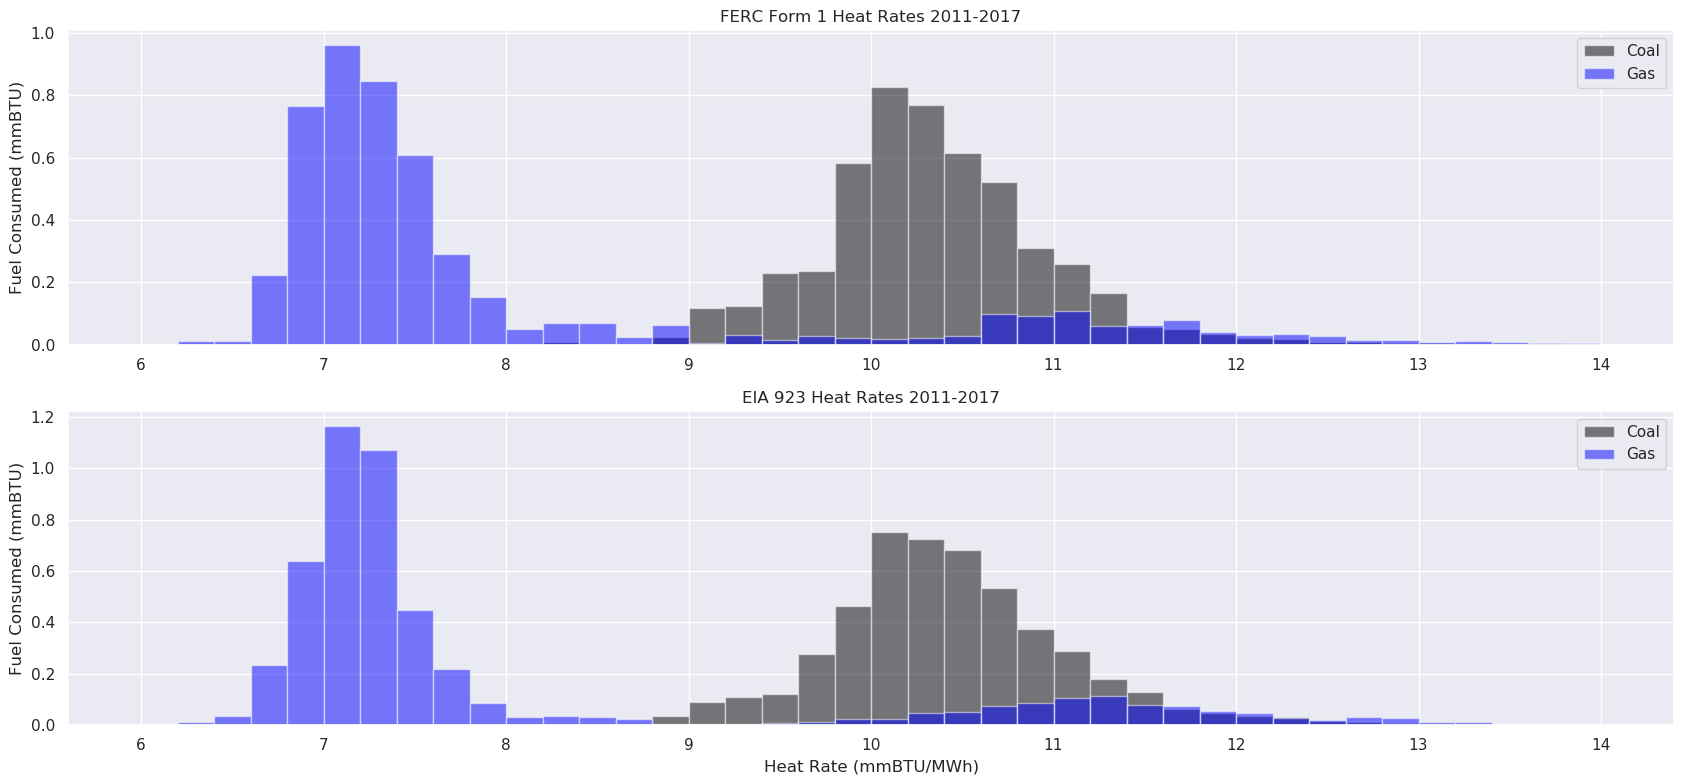

In [7]:
fig, (ferc1_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
ylabel = "Fuel Consumed (mmBTU)"
xlabel = "Heat Rate (mmBTU/MWh)"
hr_range = (6,14)
nbins=40
pdf=True

ferc1_ax.hist(ferc1_coal_plants.heat_rate_mmbtu_mwh,
             weights=ferc1_coal_plants.net_generation_mwh, alpha=0.5, color="black",
             label="Coal", density=pdf, range=hr_range, bins=nbins)
ferc1_ax.hist(ferc1_gas_plants.heat_rate_mmbtu_mwh,
             weights=ferc1_gas_plants.net_generation_mwh, alpha=0.5, color="blue",
             label="Gas", density=pdf, range=hr_range, bins=nbins)
ferc1_ax.set_ylabel(ylabel)
ferc1_ax.set_title(f"FERC Form 1 Heat Rates {start_year}-{end_year}")
ferc1_ax.legend()

eia_ax.hist(eia_coal_plants.heat_rate_mmbtu_mwh,
            weights=eia_coal_plants.net_generation_mwh, alpha=0.5, color="black",
            label="Coal", density=pdf, range=hr_range, bins=nbins)
eia_ax.hist(eia_gas_plants.heat_rate_mmbtu_mwh,
            weights=eia_gas_plants.net_generation_mwh, alpha=0.5, color="blue",
            label="Gas", density=pdf, range=hr_range, bins=nbins)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title(f"EIA 923 Heat Rates {start_year}-{end_year}")
eia_ax.legend()
plt.tight_layout()
plt.savefig("heat_rate_hist_ferc1_vs_eia.jpg")
plt.show()

## Comparing FERC & EIA Fuel Costs (\$/MWh), Grouped by PUDL Plant + Fuel

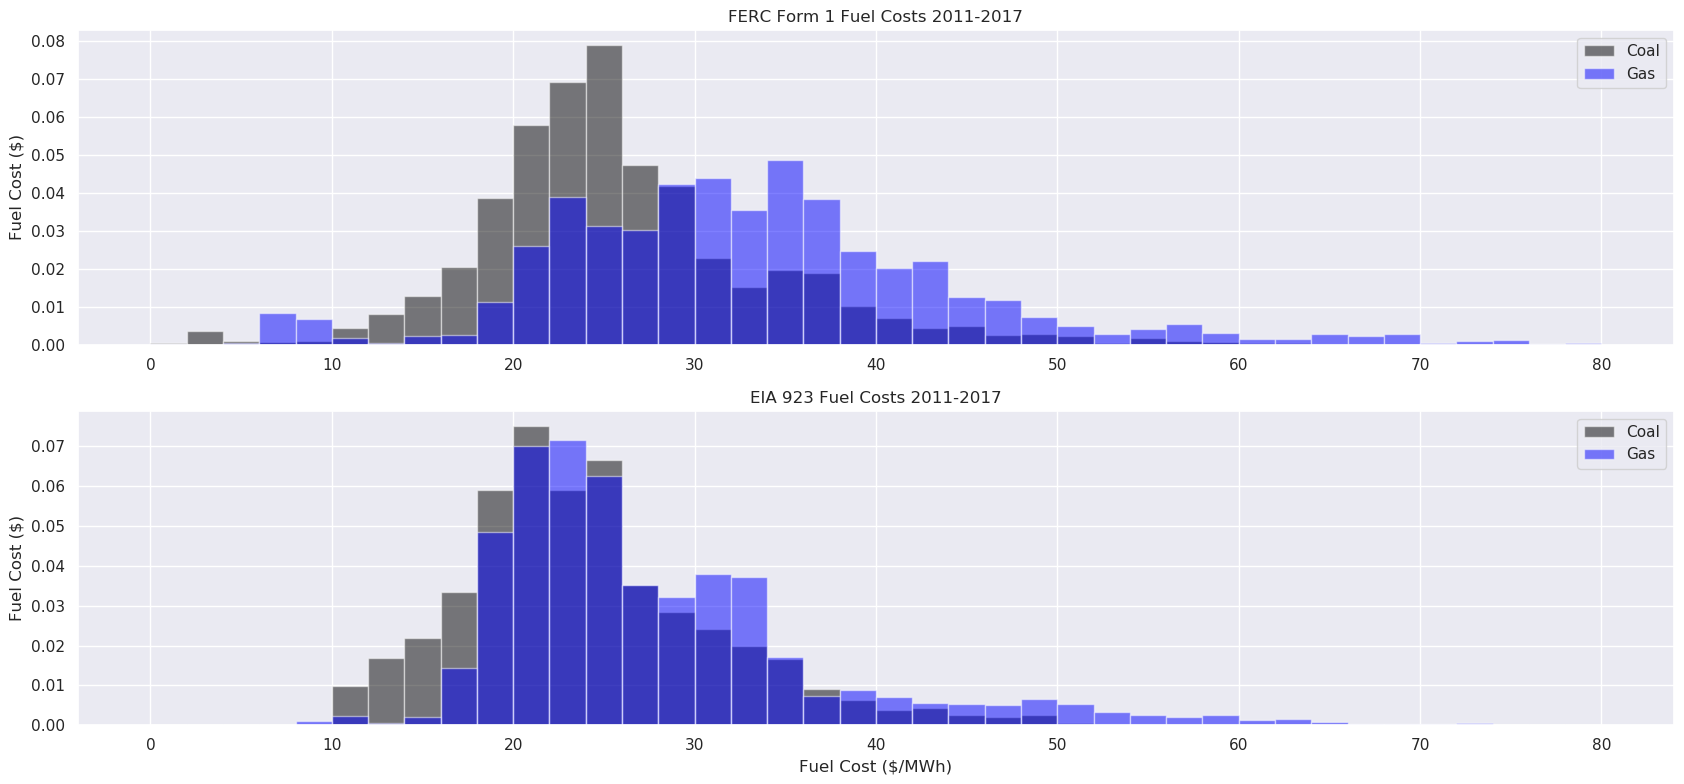

In [8]:
fig, (ferc1_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
xlabel = "Fuel Cost ($/MWh)"
ylabel = "Fuel Cost ($)"
cost_range = (0,80)
nbins=40
pdf=True

ferc1_ax.hist((ferc1_coal_plants.opex_fuel/ferc1_coal_plants.net_generation_mwh),
              range=cost_range,
              bins=nbins,
              weights=ferc1_coal_plants.net_generation_mwh,
              label="Coal",
              density=pdf,
              color="black",
              alpha=0.5)
ferc1_ax.hist((ferc1_gas_plants.opex_fuel/ferc1_gas_plants.net_generation_mwh),
              range=cost_range,
              bins=nbins,
              weights=ferc1_gas_plants.net_generation_mwh,
              label="Gas",
              density=pdf,
              color="blue",
              alpha=0.5)
ferc1_ax.set_ylabel(ylabel)
ferc1_ax.set_title(f"FERC Form 1 Fuel Costs {start_year}-{end_year}")
ferc1_ax.legend()

eia_ax.hist((eia_coal_plants.fuel_cost_per_mwh),
            range=cost_range,
            bins=nbins,
            weights=eia_coal_plants.net_generation_mwh,
            label="Coal",
            density=pdf,
            color="black",
            alpha=0.5)
eia_ax.hist((eia_gas_plants.fuel_cost_per_mwh),
            range=cost_range,
            bins=nbins,
            weights=eia_gas_plants.net_generation_mwh,
            label="Gas",
            density=pdf,
            color="blue",
            alpha=0.5)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title(f"EIA 923 Fuel Costs {start_year}-{end_year}")
eia_ax.legend()
plt.savefig("fuel_cost_hist_ferc1_vs_eia.jpg")
plt.tight_layout()
plt.show()

## PUDL Plant + Fuel Level EIA/FERC Agreement in Annual Heat Rates
 * Merge FERC & MCOE on [`report_year`, `fuel_type_code_pudl`, `plant_id_pudl`]
 
Stuff to plot (Annual):
 * Total Fuel Cost (\$)
 * Total Heat Content (mmBTU)
 * Total Net Generation (MWh)
 * Total Capacity (MW)
 * Fuel Cost (\$/MWh)
 * Fuel Cost (\$/mmBTU)
 * Heat Rate (mmBTU/MWh)
 * Capacity Factor

In [9]:
pudl_plant_cols = [
    'plant_id_pudl',
    'primary_fuel_by_mmbtu',
    'report_year',
]
eia_dude = (
    eia_plants.
    rename(columns={'total_fuel_cost': 'opex_fuel',
                    'fuel_type_code_pudl': 'primary_fuel_by_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
ferc1_dude = (
    ferc1_plants.
    rename(columns={'fuel_mmbtu': 'total_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'opex_production_total',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(opex_nonfuel_ferc=lambda x: x.opex_production_total - x.opex_fuel).
    drop('opex_production_total', axis=1).
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
pudl_dude = pd.merge(ferc1_dude, eia_dude, suffixes=('_ferc1', '_eia'), on=pudl_plant_cols)

In [10]:
def plot_eia_v_ferc1(df, fields_to_plot, xy_limits, scale="linear"):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for field in fields_to_plot:
        field_eia = field+'_eia'
        field_ferc1 = field+'_ferc1'
        fig, (coal_ax, gas_ax) = plt.subplots(ncols=2, nrows=1, figsize=(17, 8))
        
        coal_ax.scatter(df.query("primary_fuel_by_mmbtu=='coal'")[field_eia],
                        df.query("primary_fuel_by_mmbtu=='coal'")[field_ferc1],
                        color='black', alpha='0.1', label=field)
        coal_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_xlabel('EIA')
        coal_ax.set_yscale(scale)
        coal_ax.set_xscale(scale)
        coal_ax.set_ylabel('FERC Form 1')
        coal_ax.set_title(f"{field} (Coal)")
        
        gas_ax.scatter(df.query("primary_fuel_by_mmbtu=='gas'")[field_eia],
                       df.query("primary_fuel_by_mmbtu=='gas'")[field_ferc1],
                       color='blue', alpha='0.1', label=field)
        gas_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_yscale(scale)
        gas_ax.set_xscale(scale)
        gas_ax.set_xlabel('EIA')
        gas_ax.set_ylabel('FERC Form 1')
        gas_ax.set_title(f"{field} (Gas)")
        
        plt.tight_layout()
        plt.savefig(f"{field}_ferc1_vs_eia.jpg")

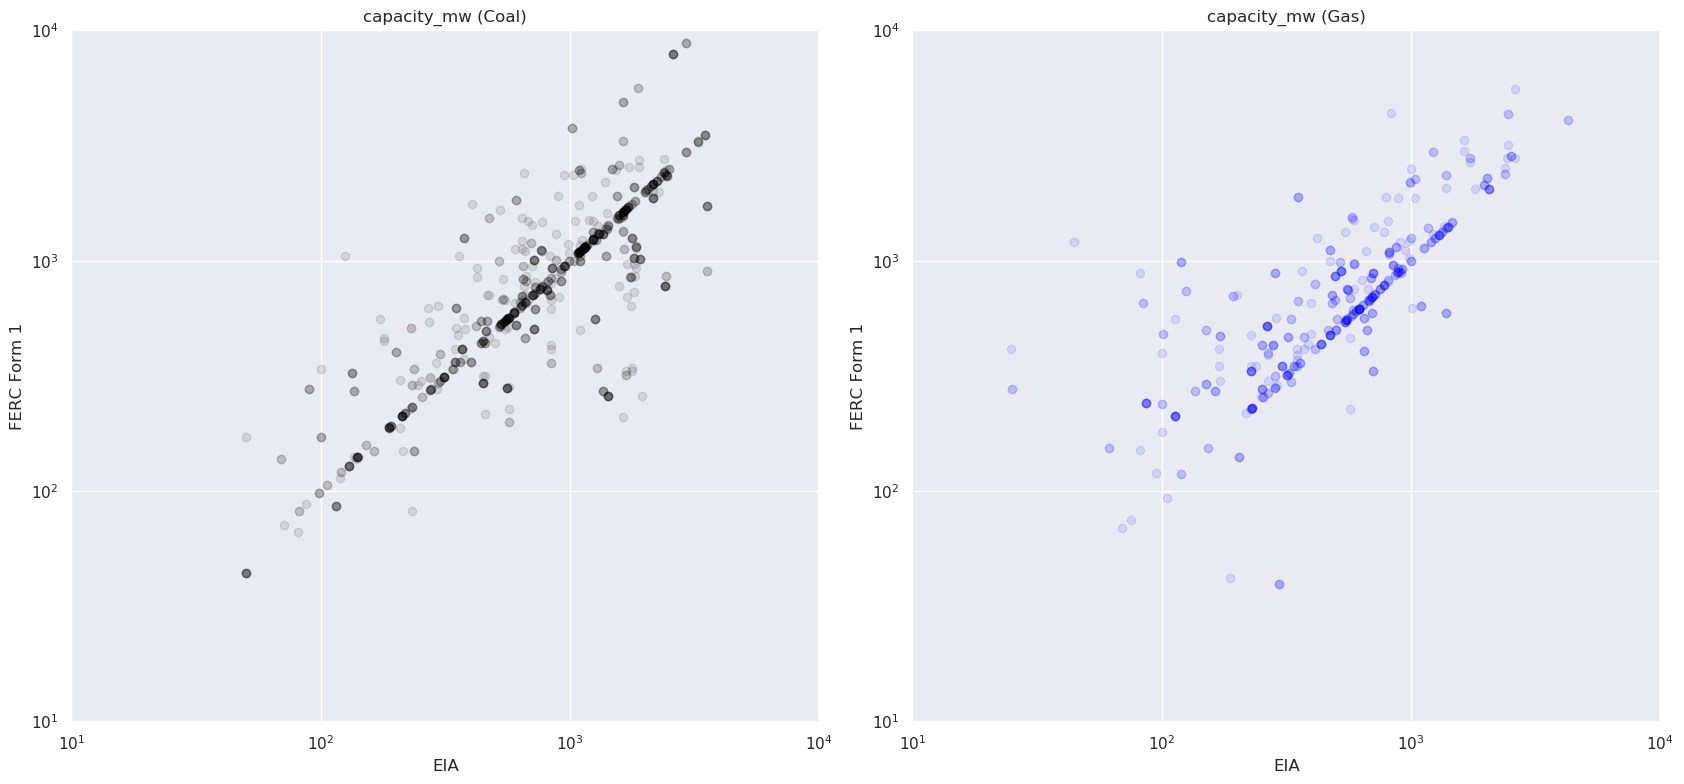

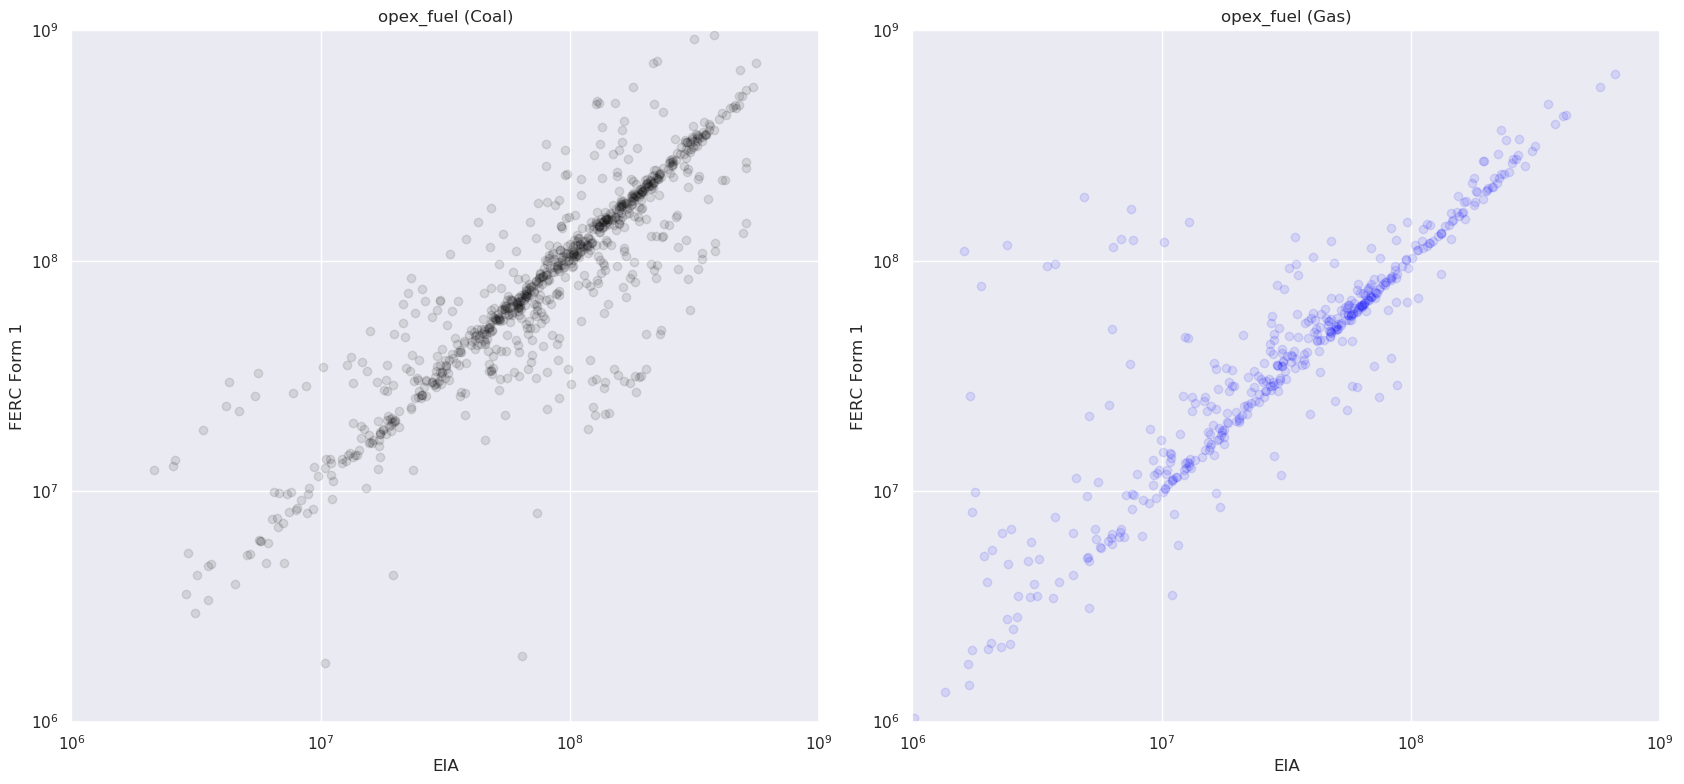

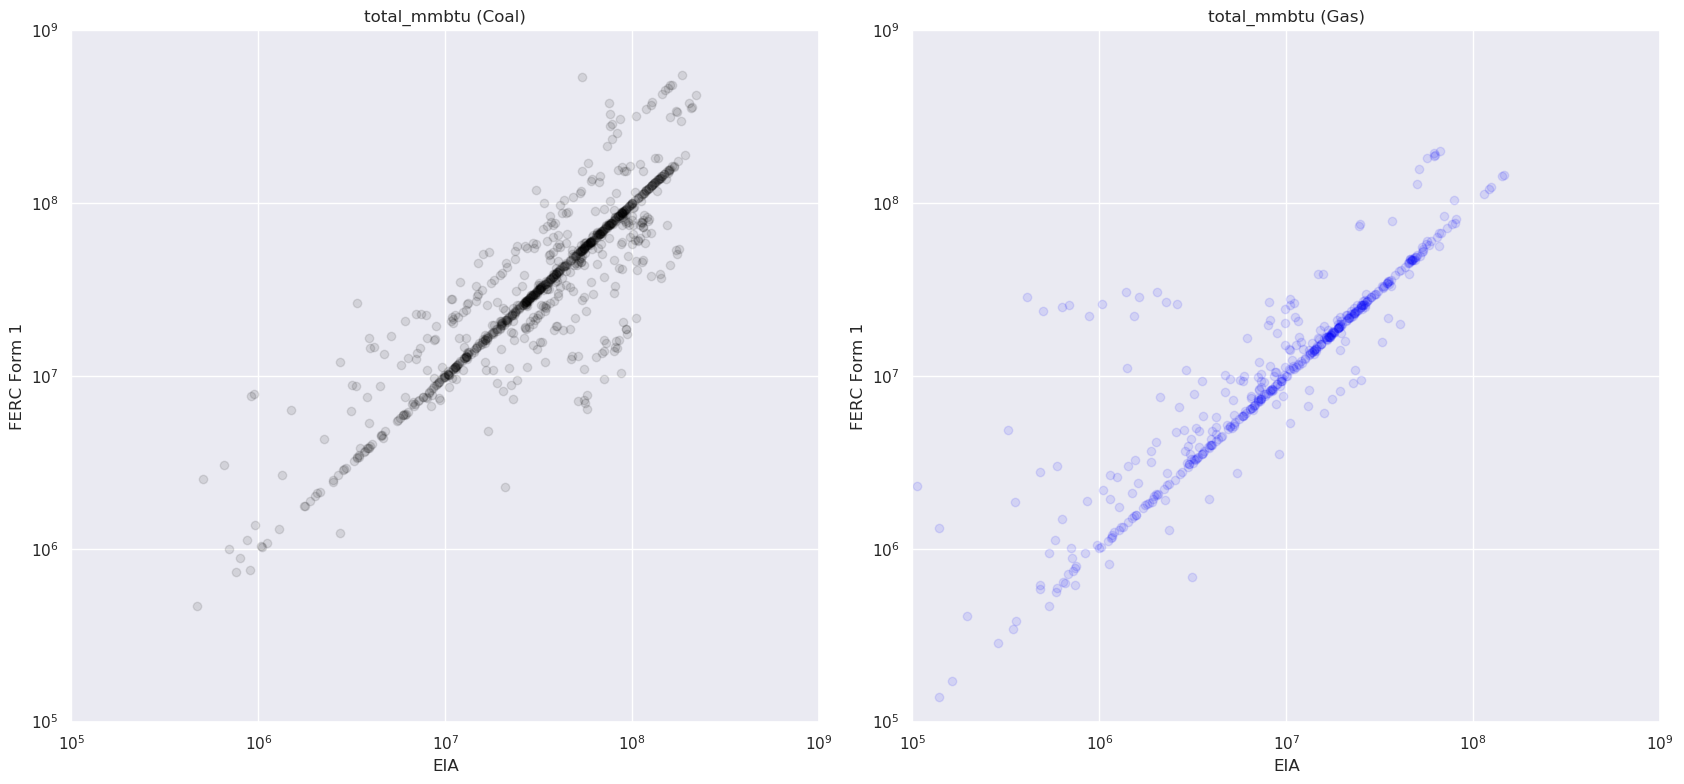

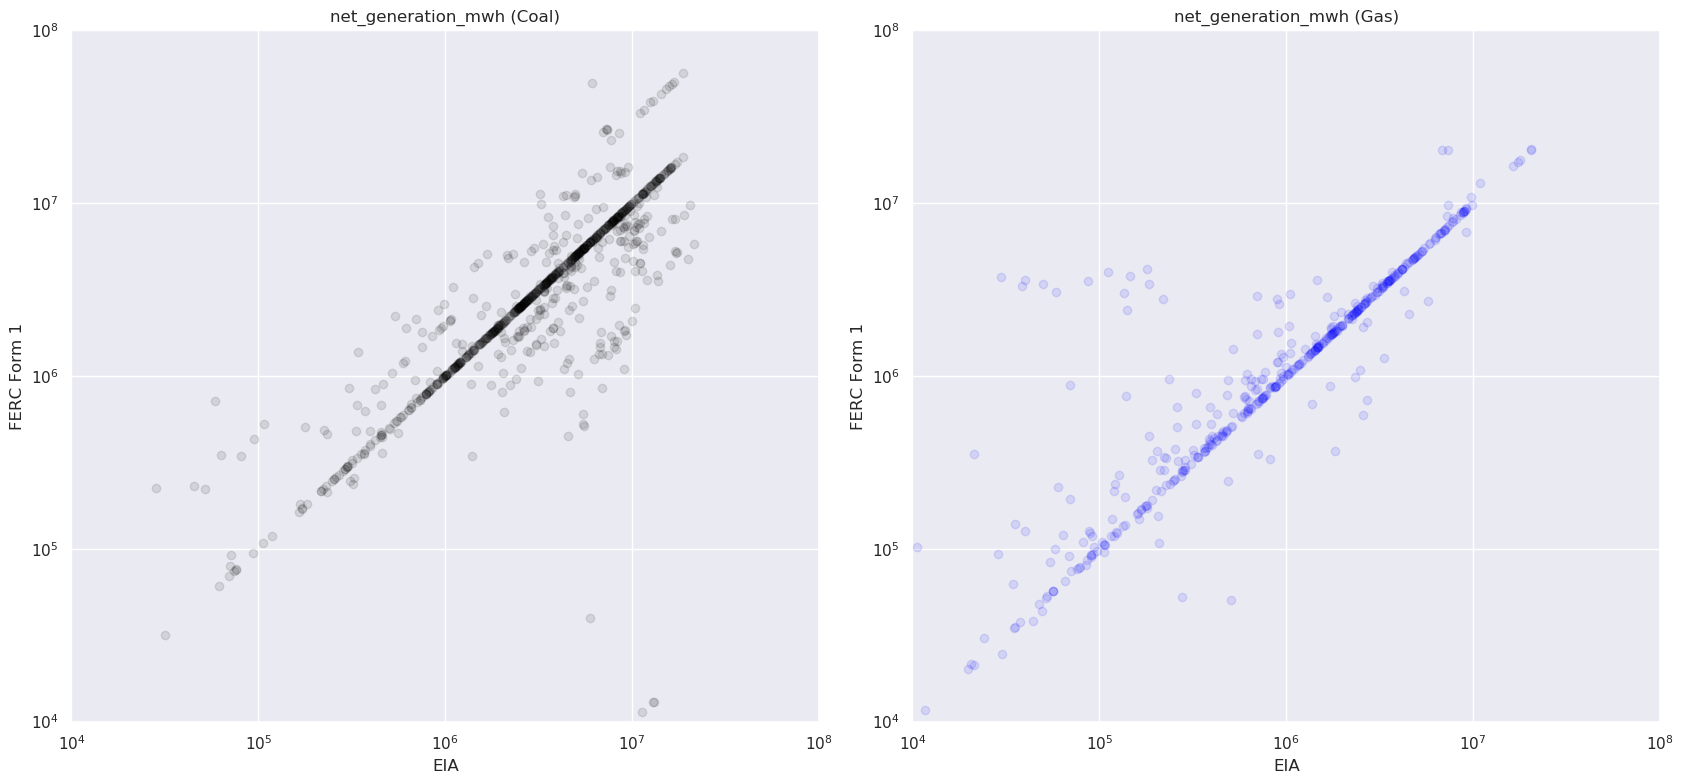

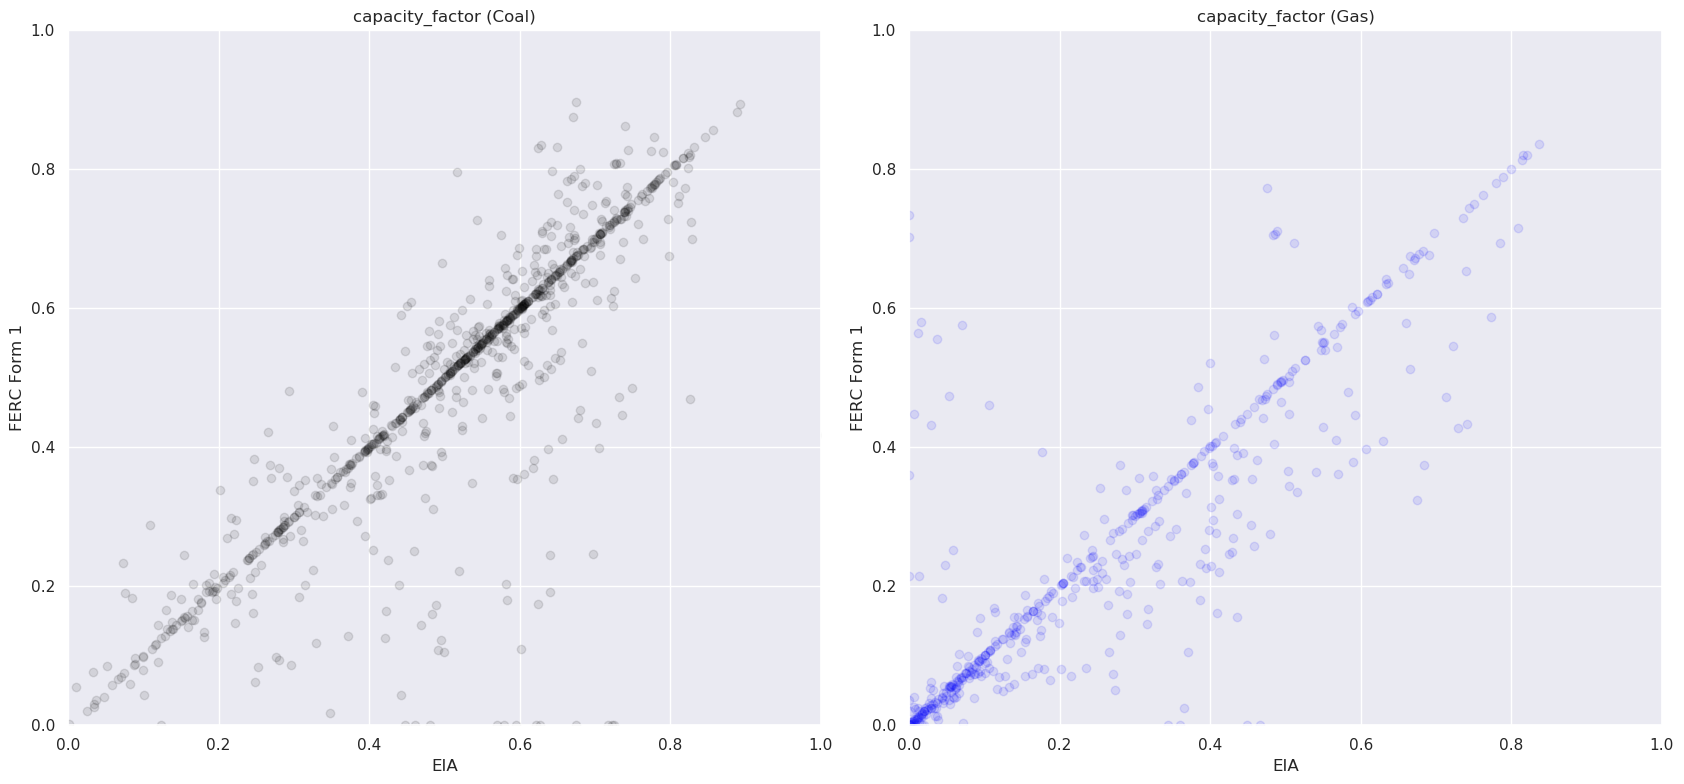

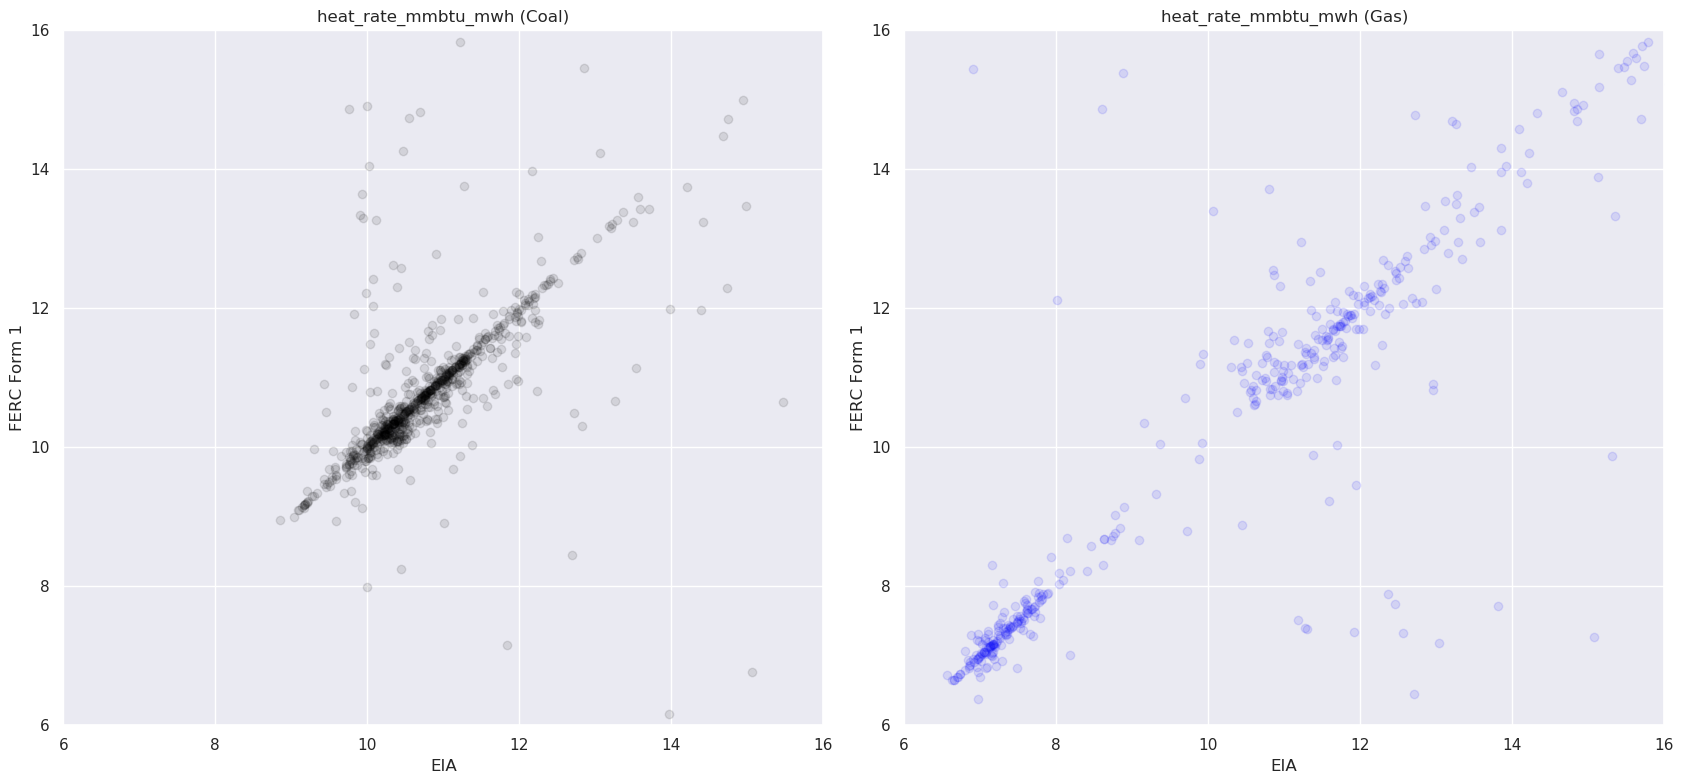

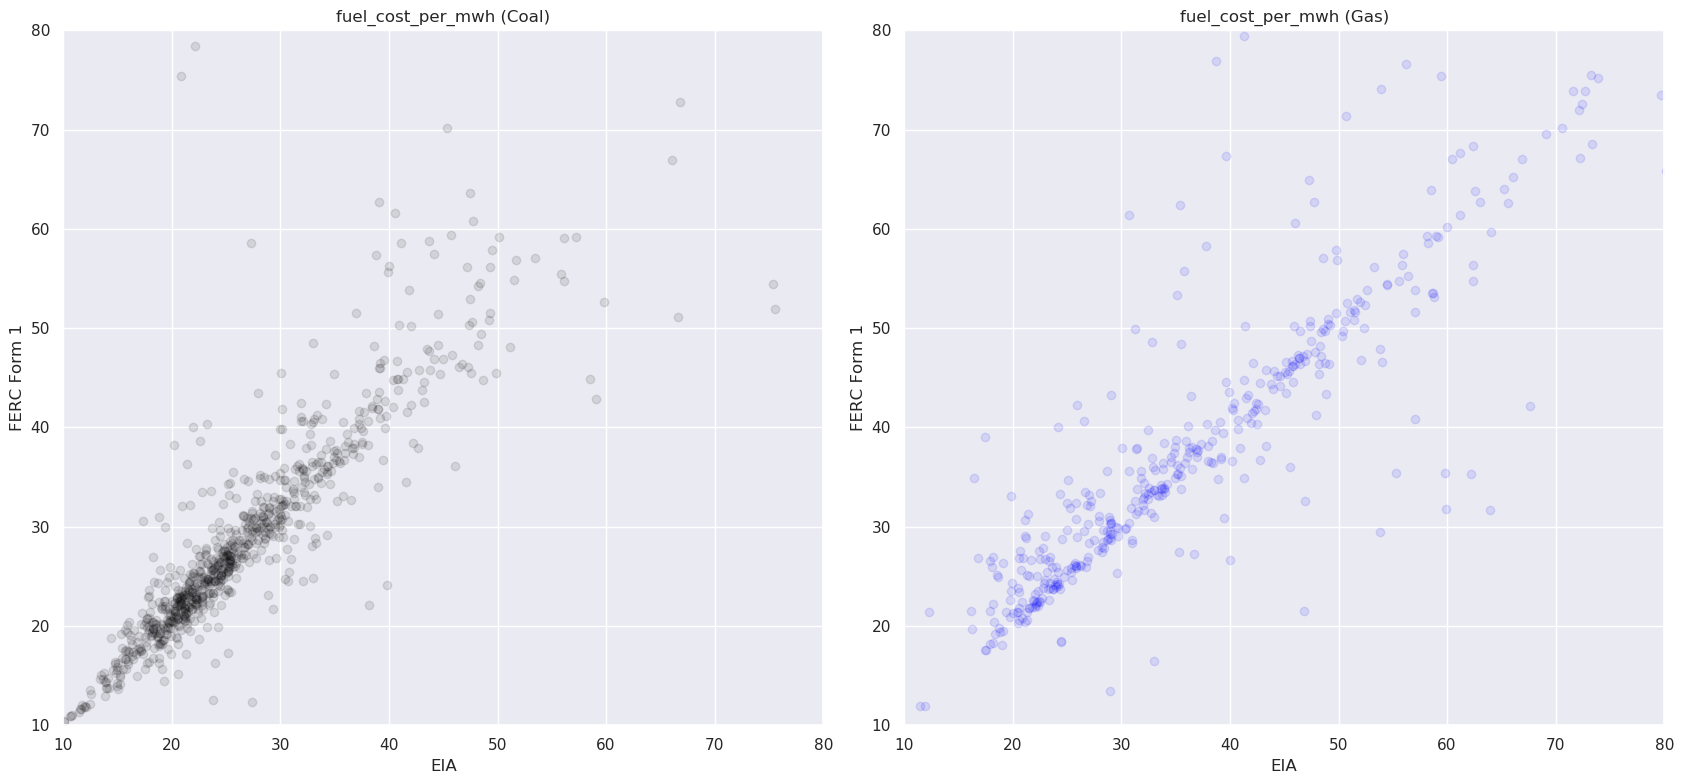

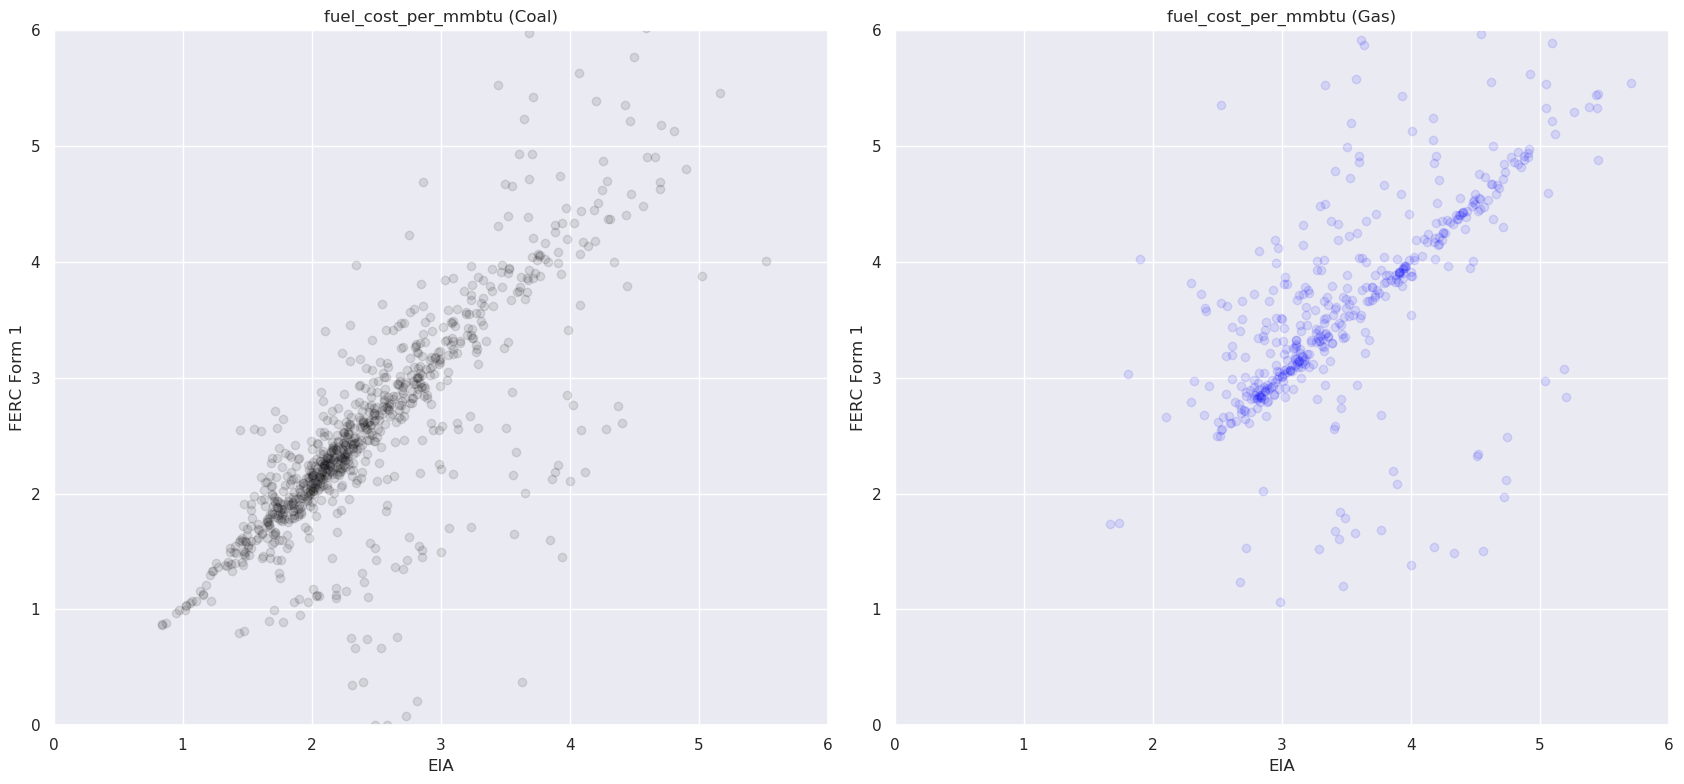

In [11]:
log_fields = [
    'capacity_mw',
    'opex_fuel',
    'total_mmbtu',
    'net_generation_mwh',
]
log_limits = {
    'capacity_mw': (1e1, 1e4),
    'opex_fuel': (1e6, 1e9),
    'total_mmbtu': (1e5,1e9),
    'net_generation_mwh': (1e4,1e8),
}

linear_fields = [
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
]
linear_limits = {
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (0,6),
}

plot_eia_v_ferc1(pudl_dude, log_fields, log_limits, scale="log")
plot_eia_v_ferc1(pudl_dude, linear_fields, linear_limits, scale="linear")